In [4]:
import numpy as np #numpy version <2.0 required
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

import pygmm

In [5]:
def mech2title(m): #mechanism name to title, to make it easier to plot without manually changing strings for titles
    if m == 'RS':
        return 'Reverse'
    elif m == 'NS':
        return 'Normal'
    elif m == 'SS':
        return 'Strike-slip'
    else:
        return ''

### Coefficients in this function from [Brengman et al., 2019](https://doi.org/10.1785/0120190048)

In [6]:
#to calculate zbor depending on a given magnitude, dip, ztop (default at surface), and coeffictients depending on mechanism
def fw2zbor(m,d,mech,ztop=0):
    if mech == 'RS':
        a = -1.569
        b = 0.426
    elif mech == 'NS':
        a = -0.8595
        b = 0.3246
    elif mech == 'SS':
        a = -0.427
        b = 0.2387
    else: #generalized coefficients if no fault mechanism is specified
        a = -1.3355
        b = 0.3897

    log_fw = a + b * m
    fw = 10 ** log_fw
    d = np.radians(d)
    zbot = (fw * np.sin(d)) + ztop

    if isinstance(zbot,np.ndarray):
        zbot = [min(z,20) for z in zbot] #bound zbot value to 20 (if given list of dip/mag)
    elif zbot > 20:
        zbot = 20 #if given a single dip and mag

    return zbot


#### Note

Capping $z_{BOR}$ at 20 km is only realistic if we are exclusively dealing with shallow crustal earthquakes (such as in the US Intermountain West). There are examples of normal faulting earthquakes with larger magnitudes and widths above 20 km:
- [2005 Taparacá earthquake](https://earthquake.usgs.gov/earthquakes/eventpage/usp000dsw1/executive)
- [2013 Khash earthquake](https://earthquake.usgs.gov/earthquakes/eventpage/usb000g7x7/executive#summary)
- [2017 Chiapas earthquake](https://earthquake.usgs.gov/earthquakes/eventpage/us2000ahv0/executive)

However, these are intraslab earthquakes, which occurred at much greater depths and did not rupture the surface. Their ground motions disperse differently to shallow earthquakes, and thus they are not as relevant to our study.

Since we are studying hanging wall vs. footwall effects, distance along strike doesn't matter much for this pygmm example. Though I wonder what the fault length <i>would</i> be, and if it's similar to the SeisSol example (30 km).

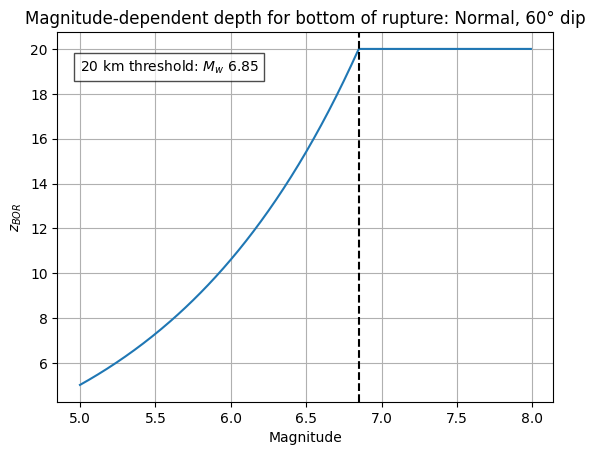

In [7]:
mags = np.arange(5,8,0.01)
dip = 60
mech = 'NS'
zbors = fw2zbor(mags,dip,mech)

for i in range(len(zbors)):
    if zbors[i] == zbors[i-1]:
        boundi = i-1
        break

mbound = mags[boundi]

plt.plot(mags,zbors)
plt.axvline(mbound,c='k',ls='--')
plt.grid()
plt.xlabel("Magnitude")
plt.ylabel('$z_{BOR}$')
plt.title(f'Magnitude-dependent depth for bottom of rupture: {mech2title(mech)}, {dip}° dip')
plt.text(5,19,s=f'20 km threshold: $M_w$ {round(mbound,2)}',bbox=dict(facecolor='white',alpha=0.7))
plt.show()

In [8]:
m = 7.440
dip = 60
mech = 'NS'
zbor = fw2zbor(m,dip,mech)

event = pygmm.Scenario(
    mag = m,
    mechanism = mech,
    dip = dip,
    region = 'california',
    v_s30 = 760,
    depth_tor = 0.0,
    depth_bor = zbor, 
    )

In [10]:
ztor = 0.0
zbor = fw2zbor(m,dip,mech)

xrup = (zbor-ztor) / np.tan(np.radians(dip))

rxs = np.linspace(-50,50,101) # 0 < x: hanging wall only; -x < 0 < x: footwall and hanging wall

xr = np.linspace(0,xrup,1001)
zr = np.linspace(ztor,zbor,1001)
rrups = np.zeros_like(rxs)
for ii, xx in enumerate(rxs):
    dist = np.sqrt((xr-xx)**2 + zr**2)
    rrups[ii] = np.min(dist)
    # if xx >= 0: rrups[ii] = r 
    # else: rrups[ii] = -r

rjbs = np.where(rxs <= xrup, 0.0, rxs-xrup)
rjbs = np.where(rxs <= 0, -rxs, rjbs)

pgv_med1 = np.zeros_like(rxs)
lpgv_std1 = np.zeros_like(rxs)
pgv_med2 = np.zeros_like(rxs)
lpgv_std2 = np.zeros_like(rxs)
pgv_med3 = np.zeros_like(rxs)
lpgv_std3 = np.zeros_like(rxs)
pgv_med4 = np.zeros_like(rxs)
lpgv_std4 = np.zeros_like(rxs)
# pgv_med5 = np.zeros_like(rxs)
# lpgv_std5 = np.zeros_like(rxs)

for ii in range(pgv_med1.size):
    scen = event.copy_with(dist_rup=rrups[ii], dist_x=rxs[ii], dist_jb=rjbs[ii], on_hanging_wall=(rxs[ii]>0))
    model1 = pygmm.AbrahamsonSilvaKamai2014(scen)
    model2 = pygmm.ChiouYoungs2014(scen)
    model3 = pygmm.BooreStewartSeyhanAtkinson2014(scen) #recommended magnitude bound: 3-7, may cause errors
    model4 = pygmm.CampbellBozorgnia2014(scen)
    # model5 = pygmm.Idriss2014(scen) #does not support normal slip

    pgv_med1[ii] = model1.pgv
    lpgv_std1[ii] = model1.ln_std_pgv
    pgv_med2[ii] = model2.pgv
    lpgv_std2[ii] = model2.ln_std_pgv
    pgv_med3[ii] = model3.pgv
    lpgv_std3[ii] = model3.ln_std_pgv
    pgv_med4[ii] = model4.pgv
    lpgv_std4[ii] = model4.ln_std_pgv
    # pgv_med5[ii] = model5.pgv
    # lpgv_std5[ii] = model5.ln_std_pgv

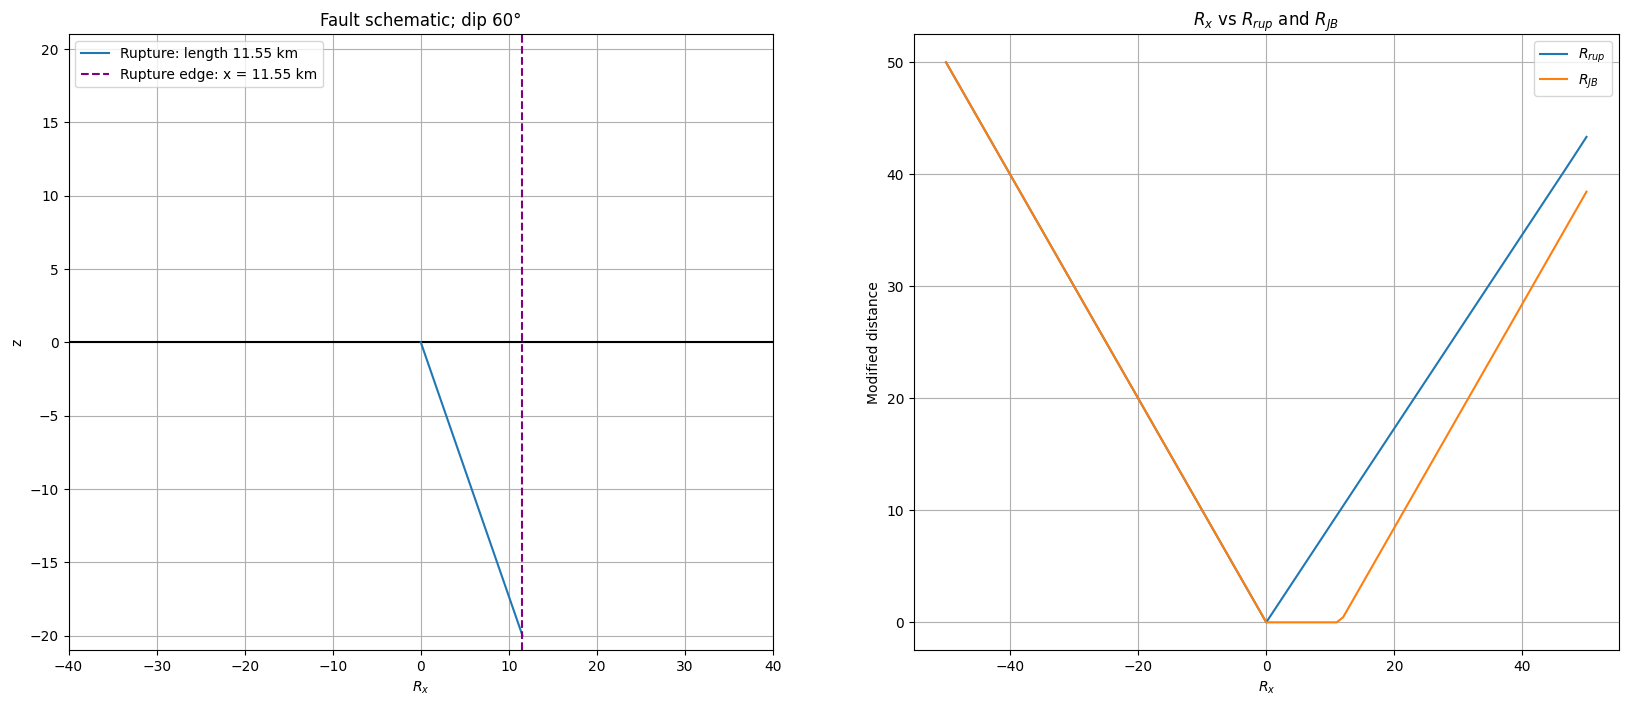

In [11]:
fig, ax = plt.subplots(1,2,figsize=[20,8])

#fault plot
fx = [0,xrup] #coordinates of top and bottom of fault
fy = [-ztor,-zbor] 
ax[0].axhline(0,color='k')
ax[0].plot(fx,fy,label=f'Rupture: length {np.round(fx,2)[1]} km')
ax[0].axvline(xrup,label=f'Rupture edge: x = {round(xrup,2)} km',color='purple',linestyle='--')
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel(f'$R_{{x}}$')
ax[0].set_ylabel(f'z')
# ax[0].set_xlim(-xrup-1,xrup+1)
ax[0].set_xlim(-40,40)
ax[0].set_ylim(-zbor-1,zbor+1)
ax[0].set_title(f'Fault schematic; dip {dip}°')

#rx vs rrup plot
ax[1].plot(rxs,rrups, label='$R_{{rup}}$')
ax[1].plot(rxs,rjbs,label='$R_{{JB}}$')
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel(f'$R_{{x}}$')
ax[1].set_ylabel(f'Modified distance')
ax[1].set_title(f'$R_{{x}}$ vs $R_{{rup}}$ and $R_{{JB}}$')
plt.show()

Text(0.5, 0.93, 'PGVs | Normal, M 7.44, 60° dip')

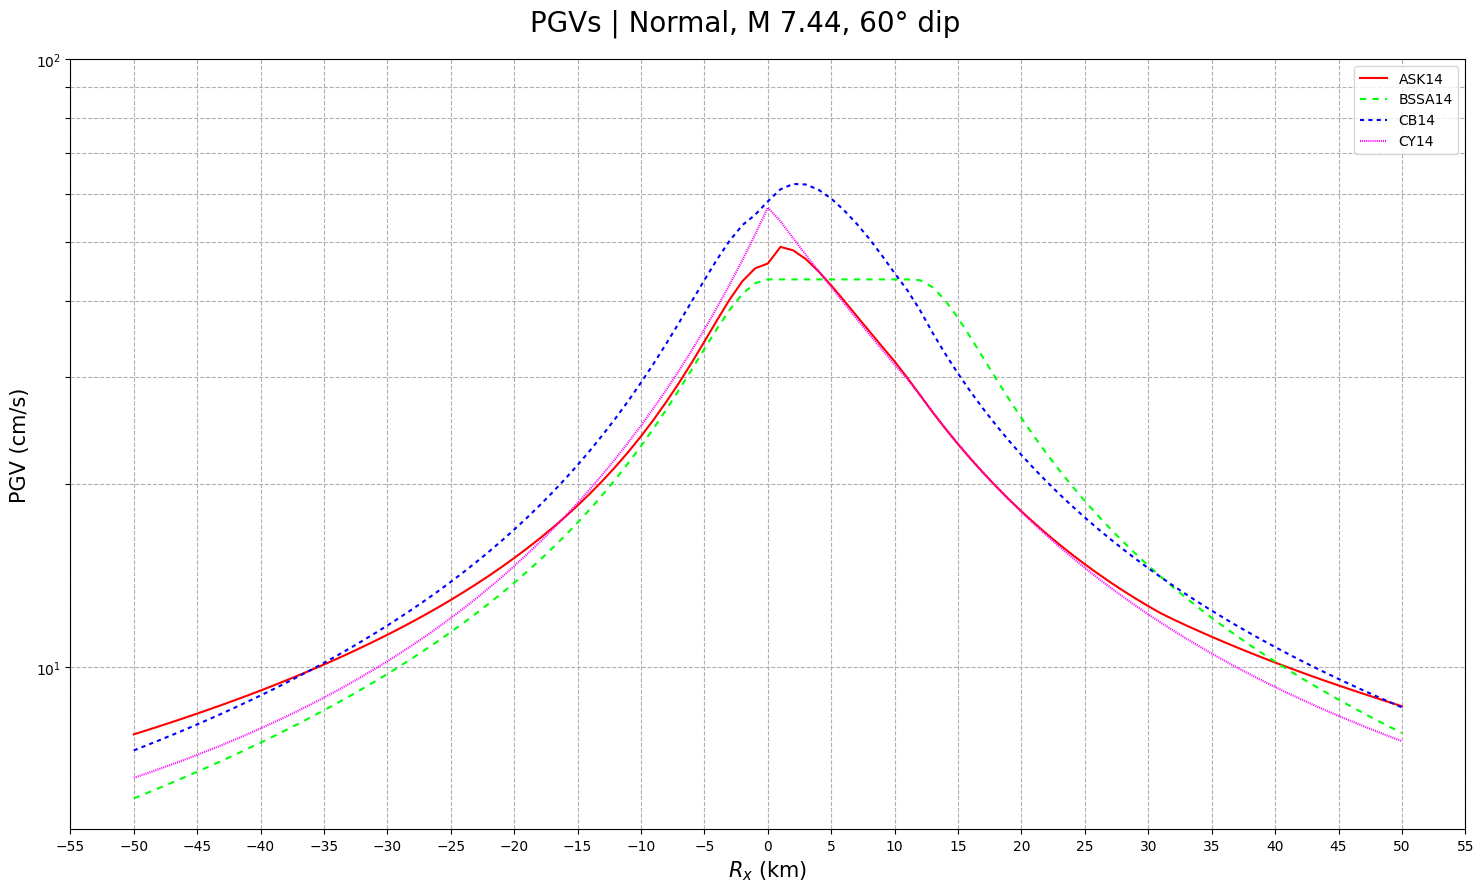

In [12]:
fig, axi = plt.subplots(figsize=[18,10])
axi.plot(rxs,pgv_med1,color='red', label='ASK14')
axi.plot(rxs,pgv_med3,color='xkcd:bright green', ls=(0,(3,3)),label='BSSA14')
axi.plot(rxs,pgv_med4,color='blue', ls=(0,(2,2)),label='CB14')
axi.plot(rxs,pgv_med2,color='magenta', ls=(0,(0.5,0.5)),label='CY14')

axi.set_ylabel('PGV (cm/s)',fontsize=15)
axi.set_xlabel(f'$R_{{x}}$ (km)',fontsize=15)

axi.set_yscale('log')
# axi.set_xlim(-30,40)

axi.xaxis.set_major_locator(ticker.MultipleLocator(5))
axi.xaxis.set_minor_locator(ticker.MultipleLocator(5))
axi.yaxis.set_major_locator(ticker.MultipleLocator(10))
axi.yaxis.set_minor_locator(ticker.MultipleLocator(10))
axi.grid(which='both',ls='--')

xmin, xmax = axi.get_xlim()
ymin, ymax = axi.get_ylim()
axi.set_ylim(ymin,100)
# axi.axhspan(0,ymax,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
# axi.axhspan(0,ymax,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')

axi.legend()

fig.suptitle(f'PGVs | {mech2title(mech)}, M {m}, {int(dip)}° dip',y=0.93, fontsize = 20)

Combined averages

In [13]:
all_models = np.stack([pgv_med1,pgv_med2,pgv_med3,pgv_med4])

log_all = np.log(all_models)
mean_log_all = np.mean(log_all,axis=0)
mean_all = np.exp(mean_log_all)

/var/folders/sn/vc1jwppj6ksd93y_fp9nbjvc0000gp/T/ipykernel_4090/173399171.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


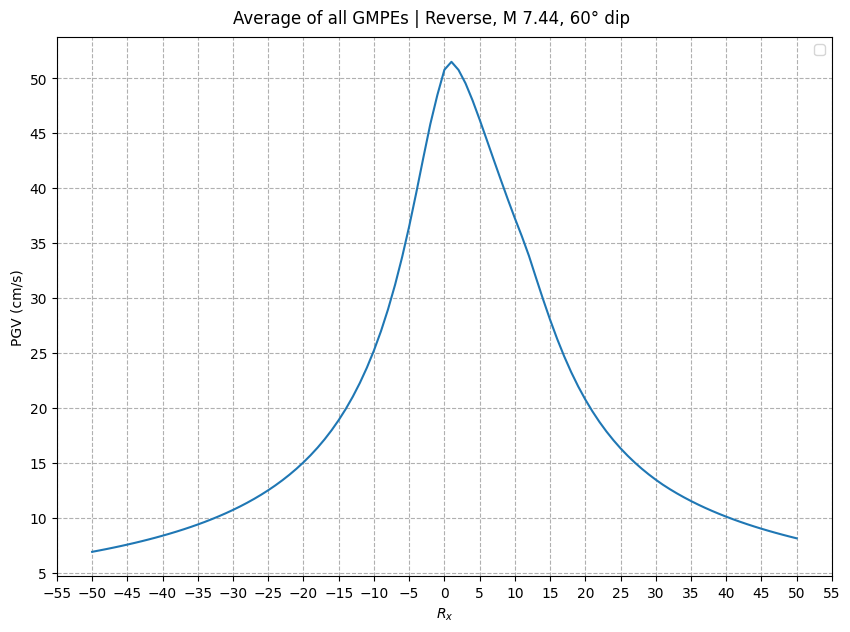

In [14]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(rxs, mean_all)
ax.set_xlabel('$R_x$')
ax.set_ylabel('PGV (cm/s)')
#ax.text(10,50,s='Lower line is PGV on the footwall, upper line is hanging wall',bbox=dict(facecolor='white',alpha=0.7))

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.grid(which='both',ls='--')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin,ymax)
# ax.axhspan(0,ymax,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
# ax.axhspan(0,ymax,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')

ax.legend()

fig.suptitle(f'Average of all GMPEs | Reverse, M {m}, {dip}° dip',y=0.92)
plt.show()

Save PGVs for comparison with SeisSol

In [15]:
df = pd.DataFrame(all_models)
df = df.transpose()
df = df.rename(columns={0: 'ask_pgv', 1: 'cy_pgv', 2: 'bssa_pgv', 3: 'cb_pgv'})
df.insert(0,'rxs',rxs)
df.head()

,rxs,ask_pgv,cy_pgv,bssa_pgv,cb_pgv
0,-50.0,7.742820,6.566009,6.074696,7.286361
1,-49.0,7.860719,6.675235,6.194339,7.425341
2,-48.0,7.982776,6.789267,6.318380,7.569836
3,-47.0,8.109230,6.908428,6.447072,7.720183
4,-46.0,8.240333,7.033063,6.580688,7.876744


Save PGVs and standard deviations

In [16]:
all_data = np.stack([pgv_med1,pgv_med2,pgv_med3,pgv_med4,lpgv_std1,lpgv_std2,lpgv_std3,lpgv_std4])
all_df = pd.DataFrame(all_data)
all_df = all_df.transpose()
all_df = all_df.rename(columns={0: 'ask_pgv', 
                                1: 'cy_pgv', 
                                2: 'bssa_pgv', 
                                3: 'cb_pgv',
                                4: 'ask_std', 
                                5: 'cy_std', 
                                6: 'bssa_std', 
                                7: 'cb_std'})
all_df.insert(0,'rxs',rxs)
all_df.head()

,rxs,ask_pgv,cy_pgv,bssa_pgv,cb_pgv,ask_std,cy_std,bssa_std,cb_std
0,-50.0,7.742820,6.566009,6.074696,7.286361,0.636003,0.538442,0.651475,0.576407
1,-49.0,7.860719,6.675235,6.194339,7.425341,0.636003,0.538439,0.651475,0.576407
2,-48.0,7.982776,6.789267,6.318380,7.569836,0.636003,0.538435,0.651475,0.576407
3,-47.0,8.109230,6.908428,6.447072,7.720183,0.636003,0.538432,0.651475,0.576407
4,-46.0,8.240333,7.033063,6.580688,7.876744,0.636003,0.538428,0.651475,0.576407


In [17]:
all_df.to_csv(f'AM_{mech}_{m}_stds.txt')

### Plotting varying dip and magnitude

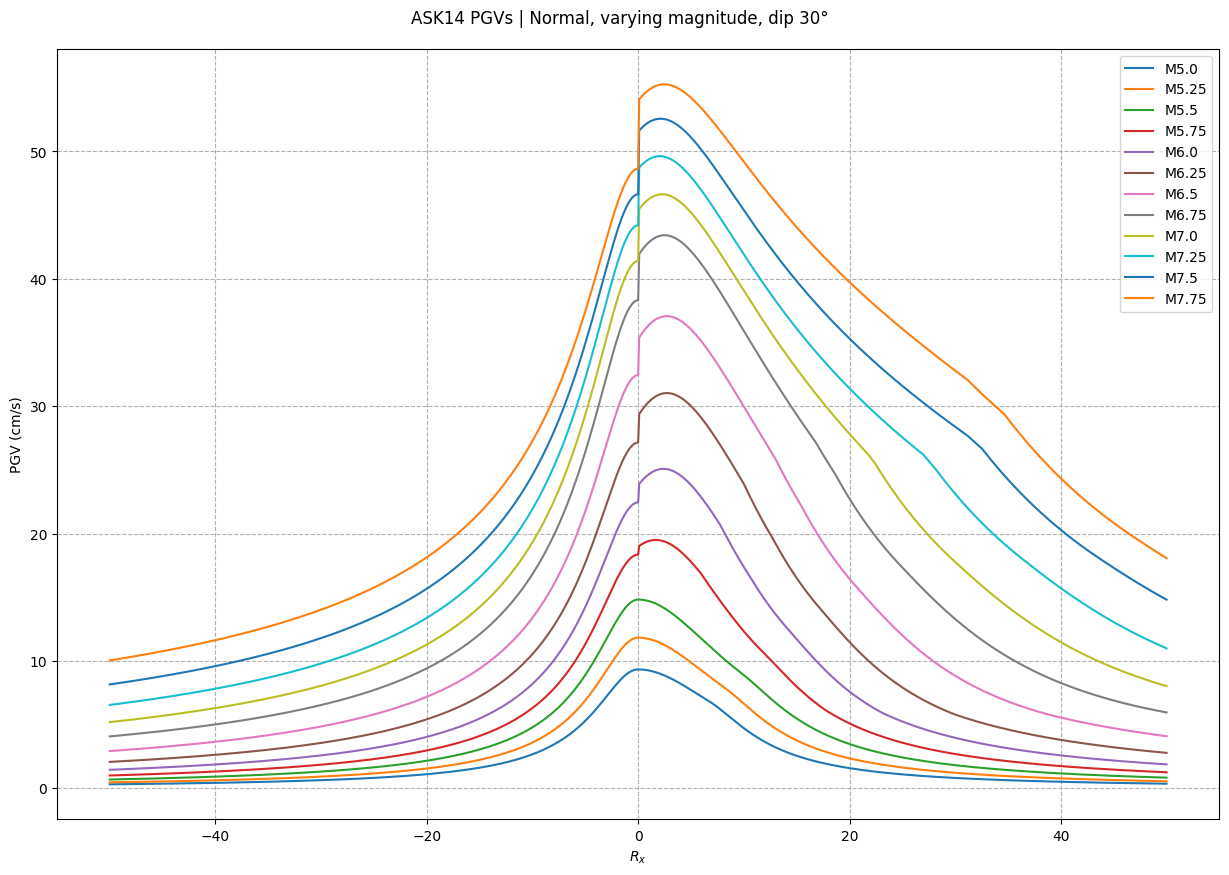

In [18]:
# dips = np.arange(25,86,10)
mags = np.arange(5,8,0.25)

fig, ax = plt.subplots(figsize=(15,10))

for i in mags:
    m = i
    dip = 30
    mech = 'NS'
    zbor = fw2zbor(m,dip,mech)

    event = pygmm.Scenario(
        mag = m,
        mechanism = mech,
        dip = dip,
        region = 'california',
        v_s30 = 760,
        depth_tor = 0.0,
        depth_bor = zbor,
        )

    ztor = 0.0
    zbor = zbor

    xrup = (zbor-ztor) / np.tan(np.radians(dip))

    rxs = np.linspace(-50,50,1001)

    xr = np.linspace(0,xrup,1001)
    zr = np.linspace(ztor,zbor,1001)
    rrups = np.zeros_like(rxs)
    for ii, xx in enumerate(rxs):
        dist = np.sqrt((xr-xx)**2 + zr**2)
        rrups[ii] = np.min(dist)
        # if xx >= 0: rrups[ii] = r 
        # else: rrups[ii] = -r

    rjbs = np.where(rxs <= xrup, 0.0, rxs-xrup)
    rjbs = np.where(rxs <= 0, -rxs, rjbs)

    pgv_med1 = np.zeros_like(rxs)
    lpgv_std1 = np.zeros_like(rxs)
    pgv_med2 = np.zeros_like(rxs)
    lpgv_std2 = np.zeros_like(rxs)
    pgv_med3 = np.zeros_like(rxs)
    lpgv_std3 = np.zeros_like(rxs)
    pgv_med4 = np.zeros_like(rxs)
    lpgv_std4 = np.zeros_like(rxs)
    # pgv_med5 = np.zeros_like(rxs)
    # lpgv_std5 = np.zeros_like(rxs)
    # print(f'computing dip {i}')

    for ii in range(pgv_med1.size):
        scen = event.copy_with(dist_rup=rrups[ii], dist_x=rxs[ii], dist_jb=rjbs[ii], on_hanging_wall=(rxs[ii]>0))
        model1 = pygmm.AbrahamsonSilvaKamai2014(scen)
        model2 = pygmm.ChiouYoungs2014(scen)
        model3 = pygmm.BooreStewartSeyhanAtkinson2014(scen) #recommended magnitude bound: 3-7, may cause errors
        model4 = pygmm.CampbellBozorgnia2014(scen)
        # model5 = pygmm.Idriss2014(scen) #does not support normal slip

        pgv_med1[ii] = model1.pgv
        lpgv_std1[ii] = model1.ln_std_pgv
        pgv_med2[ii] = model2.pgv
        lpgv_std2[ii] = model2.ln_std_pgv
        pgv_med3[ii] = model3.pgv
        lpgv_std3[ii] = model3.ln_std_pgv
        pgv_med4[ii] = model4.pgv
        lpgv_std4[ii] = model4.ln_std_pgv
        # pgv_med5[ii] = model5.pgv
        # lpgv_std5[ii] = model5.ln_std_pgv

    all_models = np.stack([pgv_med1,pgv_med2,pgv_med3,pgv_med4])

    log_all = np.log(all_models)
    mean_log_all = np.mean(log_all,axis=0)
    mean_all = np.exp(mean_log_all)
    # print(f'Plotting dip {i}')
    # ax.plot(rxs, mean_all,label=f'{i}°') #plot all averages
    ax.plot(rxs,pgv_med1,label=f'M{i}') #plot a model of your choice

ax.set_xlabel('$R_x$')
ax.set_ylabel('PGV (cm/s)')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin,ymax)
# ax.axhspan(0,ymax,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
# ax.axhspan(0,ymax,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')
# ax.axvline(x=-30,color='purple',linestyle='--', label='$R_x$ = 30km')

ax.legend()

# fig.suptitle(f'Average of all GMPEs | {mech2title(mech)}, M {m}, varying dip',y=0.92)
fig.suptitle(f'ASK14 PGVs | {mech2title(mech)}, varying magnitude, dip {dip}°',y=0.92)
# ax.text(xmin+10,ymax-10,s='GMPEs averaged:\n\u2022ASK14 \n\u2022CY14 \n\u2022BSSA \n\u2022CB14',bbox=dict(facecolor='white',alpha=0.7))
plt.grid(linestyle='--')
plt.show()